In [ ]:
# Install openai python library
!pip install openai==1.54.1
import pandas as pd
from IPython.display import display
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import openai
import matplotlib.pyplot as plt

##Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/mtsamples.csv')

##Understanding the data




In [ ]:
#Understanding the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB
None


In [ ]:
#Shape of the dataset
print(df.columns)
print(df.shape)

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')
(4999, 6)


In [ ]:
#Dropping the column
df = df.drop('Unnamed: 0', axis=1)

In [ ]:
# Getting an idea of null values
null_counts = df.isnull().sum()
print(null_counts)

description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64


In [ ]:
df = df.dropna(subset=['transcription', 'keywords'])


In [ ]:
print(df.shape)

(3898, 5)


## Creating a new dataset:


In [ ]:
sampled_df = df.sample(n=500, random_state=42)

In [ ]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 4700 to 3614
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        500 non-null    object
 1   medical_specialty  500 non-null    object
 2   sample_name        500 non-null    object
 3   transcription      500 non-null    object
 4   keywords           500 non-null    object
dtypes: object(5)
memory usage: 23.4+ KB


In [ ]:
sampled_df.describe()

,description,medical_specialty,sample_name,transcription,keywords
count,500,500,500,500,500
unique,458,37,460,460,493
top,A ight-handed inpatient with longstanding his...,Surgery,EMG/Nerve Conduction Study - 2,"HISTORY: , The patient is a 78-year-old right-...",
freq,3,138,3,3,8


In [ ]:
sampled_df.head()

,description,medical_specialty,sample_name,transcription,keywords
4700,Consult for subcutaneous emphysema and a smal...,Cardiovascular / Pulmonary,Pneumothorax & Subcutaneous Emphysema,"REASON FOR CONSULTATION:, Pneumothorax and su...","cardiovascular / pulmonary, trauma, tracheobro..."
988,"Colonoscopy, conscious sedation, and snare po...",Surgery,Colonoscopy & Polypectomy - 2,"PREPROCEDURE DIAGNOSIS: , Colon cancer screeni...","surgery, colon polyps, diverticulosis, hemorrh..."
346,Endoscopic proximal shunt revision.,Surgery,Shunt Revision - 1,"PREOPERATIVE DIAGNOSIS: , Shunt malfunction. ...","surgery, ventriculoatrial shunt, endoscopic pr..."
2384,Ruptured globe with full-thickness corneal la...,Ophthalmology,Ruptured Globe Repair - Cornea,"PREOPERATIVE DIAGNOSIS:, Ruptured globe with ...","ophthalmology, ruptured globe, alphagan, bss, ..."
1628,Bilateral Screening Mammogram Full-Field Digi...,Radiology,Full-Field Digital Mammogram (FFDM) - 1,"EXAM: , Digital screening mammogram.,HISTORY:,...","radiology, mediolateral, craniocaudal, fibrogl..."


In [ ]:
unique_medical_specialties = sampled_df['medical_specialty'].unique()
print(unique_medical_specialties)

[' Cardiovascular / Pulmonary' ' Surgery' ' Ophthalmology' ' Radiology'
 ' Orthopedic' ' Emergency Room Reports' ' Neurosurgery' ' Podiatry'
 ' Cosmetic / Plastic Surgery' ' General Medicine'
 ' Consult - History and Phy.' ' Bariatrics'
 ' SOAP / Chart / Progress Notes' ' Urology' ' ENT - Otolaryngology'
 ' Discharge Summary' ' Obstetrics / Gynecology' ' Endocrinology'
 ' Pediatrics - Neonatal' ' Neurology' ' Physical Medicine - Rehab'
 ' Office Notes' ' Speech - Language' ' Dermatology' ' Nephrology'
 ' Lab Medicine - Pathology' ' Gastroenterology' ' Hematology - Oncology'
 ' Pain Management' ' Psychiatry / Psychology' ' Letters' ' Dentistry'
 ' Sleep Medicine' ' Allergy / Immunology' ' Chiropractic' ' Rheumatology'
 ' Diets and Nutritions']


## Evaluation Method

In [ ]:
_open_ai_tkn=your_openai_api_key
_project_tkn=your_project_token
_organisation_tkn=your_organisation_token

In [ ]:
# create client endpoint for accessing remote LLM
from openai import OpenAI

client = OpenAI(
  api_key=_open_ai_tkn,
  organization=_organisation_tkn,
  project=_project_tkn
)


In [ ]:
# Making requests to OpenAI to retrieve predictions
def predict_medical_specialty(prompt, output_col):
  predictions = []
  for index, row in sampled_df.iterrows():
      transcription = row['transcription']
      keywords = row['keywords']
      description = row['description']
      response = client.chat.completions.create(
          messages=[{
              "role": "user",
              "content": prompt(description, transcription, keywords)
          }],
          model="gpt-4o-mini",
          max_completion_tokens=100
      )
      predictions.append(response.choices[0].message.content)


  # display(predictions)
  sampled_df[output_col] = predictions


In [ ]:
def compare_with_label(checking_col, ans_col):
  for index, row in sampled_df.iterrows():
      ai_output = row[checking_col].lower()
      original_output = row['medical_specialty'].lower()
      if ai_output == original_output or ai_output in original_output or original_output in ai_output:
          sampled_df.at[index, ans_col] = True
      else:
          sampled_df.at[index, ans_col] = False
  ture_val = len(sampled_df.loc[sampled_df[ans_col] == True, ['medical_specialty', checking_col, ans_col]])
  false_val = len(sampled_df.loc[sampled_df[ans_col] == False, ['medical_specialty', checking_col, ans_col]])
  print(f"True values: {ture_val} / 500")
  print(f"False values: {false_val} / 500")
  print(f"Accuracy: {ture_val / 500 * 100}%")

## Evaluation Method 1

In [ ]:
def prompt1(description, transcription, keywords):
  return f"""
  "You are provided with the following information about a medical case:

  Description: {description}
  Transcription: {transcription}
  Keywords: {keywords}

  Based on this information, predict the medical specialty that best fits this case. Provide your answer in one word."
  """

In [ ]:
predict_medical_specialty(prompt1, 'eval_1_output')
compare_with_label('eval_1_output', 'eval_1_ans')

True values: 163 / 500
False values: 337 / 500
Accuracy: 32.6%


## Evaluation Method 2

In [ ]:
def prompt2(description, transcription, keywords):
  return f"""
  "You are provided with the following information about a medical case:

  Description: {description}
  Transcription: {transcription}
  Keywords: {keywords}

  Based on this information, predict the medical specialty that best fits this case.
  Choose the specialty from the following list and provide your answer in one word:

  ['Cardiovascular / Pulmonary', 'Surgery', 'Ophthalmology', 'Radiology', 'Orthopedic', 'Emergency Room Reports', 'Neurosurgery', 'Podiatry',
  'Cosmetic / Plastic Surgery', 'General Medicine', 'Consult - History and Phy.', 'Bariatrics', 'SOAP / Chart / Progress Notes',
  'Urology', 'ENT - Otolaryngology', 'Discharge Summary', 'Obstetrics / Gynecology', 'Endocrinology', 'Pediatrics - Neonatal',
  'Neurology', 'Physical Medicine - Rehab', 'Office Notes', 'Speech - Language', 'Dermatology', 'Nephrology', 'Lab Medicine - Pathology',
  'Gastroenterology', 'Hematology - Oncology', 'Pain Management', 'Psychiatry / Psychology', 'Letters', 'Dentistry', 'Sleep Medicine',
  'Allergy / Immunology', 'Chiropractic', 'Rheumatology', 'Diets and Nutritions']"
  """


In [ ]:
predict_medical_specialty(prompt2, 'eval_2_output')
compare_with_label('eval_2_output', 'eval_2_ans')

True values: 258 / 500
False values: 242 / 500
Accuracy: 51.6%


##EVALUATION METHOD 3:


The evaluation method compares ChatGPT's predicted medical specialties with actual specialties by leveraging vector embeddings and cosine similarity. Predictions are generated using a structured prompt and converted, along with the actual specialties, into embeddings via the text-embedding-ada-002 model.

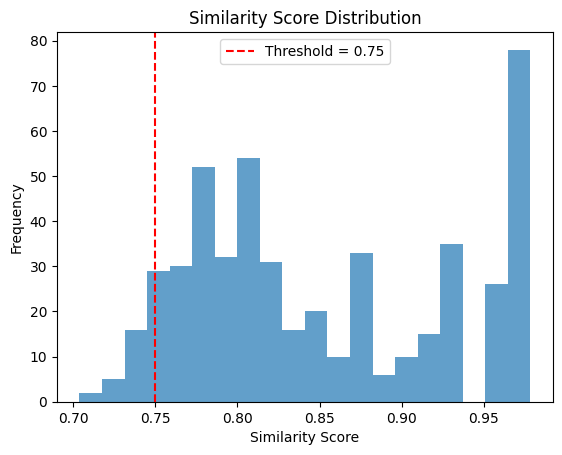

True values: 470 / 500
False values: 30 / 500
Overall Accuracy: 94.00%


,description,medical_specialty,sample_name,transcription,keywords,eval_1_output,eval_1_ans,similarity,eval_3_ans
4700,Consult for subcutaneous emphysema and a smal...,Cardiovascular / Pulmonary,Pneumothorax & Subcutaneous Emphysema,"REASON FOR CONSULTATION:, Pneumothorax and su...","cardiovascular / pulmonary, trauma, tracheobro...",Pulmonary,True,0.905756,True
988,"Colonoscopy, conscious sedation, and snare po...",Surgery,Colonoscopy & Polypectomy - 2,"PREPROCEDURE DIAGNOSIS: , Colon cancer screeni...","surgery, colon polyps, diverticulosis, hemorrh...",Gastroenterology,False,0.788097,True
346,Endoscopic proximal shunt revision.,Surgery,Shunt Revision - 1,"PREOPERATIVE DIAGNOSIS: , Shunt malfunction. ...","surgery, ventriculoatrial shunt, endoscopic pr...",Neurosurgery,False,0.799818,True
2384,Ruptured globe with full-thickness corneal la...,Ophthalmology,Ruptured Globe Repair - Cornea,"PREOPERATIVE DIAGNOSIS:, Ruptured globe with ...","ophthalmology, ruptured globe, alphagan, bss, ...",Ophthalmology,True,0.968047,True
1628,Bilateral Screening Mammogram Full-Field Digi...,Radiology,Full-Field Digital Mammogram (FFDM) - 1,"EXAM: , Digital screening mammogram.,HISTORY:,...","radiology, mediolateral, craniocaudal, fibrogl...",Radiology,True,0.978311,True
...,...,...,...,...,...,...,...,...,...
4921,Left cardiac catheterization with selective r...,Cardiovascular / Pulmonary,Cardiac Cath & Selective Coronary Angiography,"PREOPERATIVE DIAGNOSIS: , Post infarct angina....","cardiovascular / pulmonary, selective, angiogr...",Cardiology,False,0.880368,True
1410,Dietary consultation for gestational diabetes.,SOAP / Chart / Progress Notes,Dietary Consult - Gestational Diabetes,"SUBJECTIVE:, This is a 38-year-old female who...","soap / chart / progress notes, blood sugars, f...",Nutrition,False,0.721287,False
212,Umbilical hernia repair. A standard curviline...,Surgery,Umbilical Hernia Repair - 1,"PROCEDURE PERFORMED: , Umbilical hernia repair...","surgery, fascial defect, umbilical hernia repa...",Surgery,True,0.826987,True
4762,"Nonischemic cardiomyopathy, branch vessel cor...",Cardiovascular / Pulmonary,Hypertension & Cardiomyopathy,"PROBLEMS LIST:,1. Nonischemic cardiomyopathy....","cardiovascular / pulmonary, congestive heart f...",Cardiology,False,0.880316,True


In [ ]:
def get_embeddings(texts, model):
    response = client.embeddings.create(
        input=texts,
        model=model
    )
    return [res.embedding for res in response.data]

def evaluate_predictions(predicted_col, actual_col, threshold):
    # Get all predicted and actual answers
    predicted_texts = sampled_df[predicted_col].tolist()
    actual_texts = sampled_df[actual_col].tolist()

    # Get embeddings for all texts in batches
    predicted_embeddings = get_embeddings(predicted_texts, "text-embedding-ada-002")
    actual_embeddings = get_embeddings(actual_texts, "text-embedding-ada-002")

    # Compute cosine similarities for all pairs
    similarities = [
        cosine_similarity([pred_emb], [act_emb])[0][0]
        for pred_emb, act_emb in zip(predicted_embeddings, actual_embeddings)
    ]

    # Add similarity scores and correctness to DataFrame
    sampled_df['similarity'] = similarities
    sampled_df['eval_3_ans'] = sampled_df['similarity'] >= threshold

def visualize_results():
    # Plot histogram of similarity scores
    plt.hist(sampled_df['similarity'], bins=20, alpha=0.7)
    plt.axvline(0.75, color='red', linestyle='--', label='Threshold = 0.75')
    plt.title('Similarity Score Distribution')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Display overall accuracy
    true_count = sampled_df['eval_3_ans'].sum()
    false_count = len(sampled_df) - true_count
    accuracy = sampled_df['eval_3_ans'].mean() * 100
    print(f"True values: {true_count} / 500")
    print(f"False values: {false_count} / 500")
    print(f"Overall Accuracy: {accuracy:.2f}%")


evaluate_predictions('eval_1_output', 'medical_specialty', threshold=0.75)
visualize_results()

# Display updated DataFrame
display(sampled_df)
